### Source code

In [4]:
import os
import pandas as pd
from calendar import monthrange

def dt_to_minutes(delta):
    return delta.seconds // 60 % 60


class LoadGenerator(object):
    def __init__(self, folder, init_date, delta_t, np_random, p_max=1.):
        self.folder = folder
        self.np_random = np_random
        self.p_max = p_max
        self.delta_t = delta_t
        self.date = init_date

        self.scale = 0.005
        self.prev_month = None
        self.prev_day = None
        self.prev_p = None

    def __iter__(self):
        return self

    def __next__(self):

        # A new month is reached.
        if self.date.month != self.prev_month or self.prev_month is None:
            self._load_month_curves()

        # A new day is reached.
        if self.date.day != self.prev_day or self.prev_day is None:
            self._load_day_base_curve()

        # Initialize the previous injection at the first time step.
        if self.prev_p is None:
            self.prev_p = self.day_curve[0]

        delta_min = dt_to_minutes(self.delta_t)

        t = int((self.date.hour * 60 + self.date.minute) / delta_min)
        diff = self.day_curve[t - 1] - self.prev_p
        noise = self.np_random.normal(loc=diff, scale=self.scale)

        self.prev_p += noise

        # Increment the current time.
        self.date += self.delta_t

        return self.prev_p * self.p_max

    def next(self):
        if self.date.minute % self.delta_t:
            raise ValueError('The time should be a multiple of delta_t.')

        return self.__next__()

    def _load_month_curves(self):
        path = os.path.join(self.folder, f'curves_{self.date.month - 1}.csv')
        self.month_curves = pd.read_csv(path, header=None).values
        self.prev_month = self.date.month

    def _load_day_base_curve(self):
        rand_day = self.np_random.randint(0, monthrange(self.date.year,
                                                        self.date.month)[1])
        self.day_curve = self.month_curves[rand_day - 1, :]
        self.prev_day = self.date.day

### Initialize generators of load time series

In [9]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [25]:
P_max = [10, 20]
loads = []
folder = os.path.join(os.getcwd(), 'data_demand_curves', 'house')
init_date = dt.datetime(2019, 1, 1)
delta_t = dt.timedelta(minutes=15)
np_random = np.random.RandomState(2019)

for p_max in P_max:
    new_load = LoadGenerator(folder, init_date, delta_t, np_random,
                             p_max)
    loads.append(new_load)

### Display curves generated by those loads over the same period

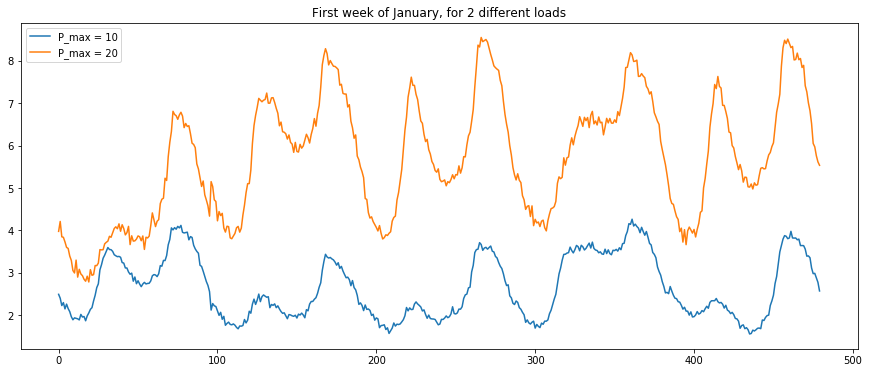

In [19]:
plt.figure(figsize=(15, 6))
for i, load in enumerate(loads):
    series = []
    for _ in range(4*24*5):
        series.append(next(load))
    plt.plot(series, label=f'P_max = {P_max[i]}')
plt.title('First week of January, for 2 different loads')
plt.legend()

### Display curves generated by a load at different times of the year

In [22]:
p_max = 10
load_months = []
for month in [1, 4, 7, 10]:
    init_date = dt.datetime(2019, month, 1)
    new_load = LoadGenerator(folder, init_date, delta_t, np_random,
                         p_max)
    load_months.append(new_load)

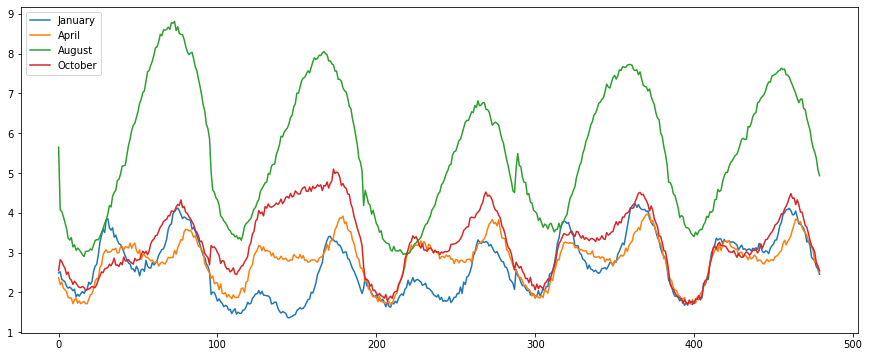

In [23]:
plt.figure(figsize=(15, 6))
months = ['January', 'April', 'August', 'October']
for i, load in enumerate(load_months):
    series = []
    for _ in range(4*24*5):
        series.append(next(load))
    plt.plot(series, label=months[i])
plt.title('')
plt.legend()

### Same thing with a factory

In [55]:
folder = os.path.join(os.getcwd(), 'data_demand_curves', 'factory')
np_random = np.random.RandomState(2018)

p_max = 10
load_months = []
for month in [1, 4, 7, 10]:
    init_date = dt.datetime(2019, month, 1)
    new_load = LoadGenerator(folder, init_date, delta_t, np_random,
                         p_max)
    load_months.append(new_load)

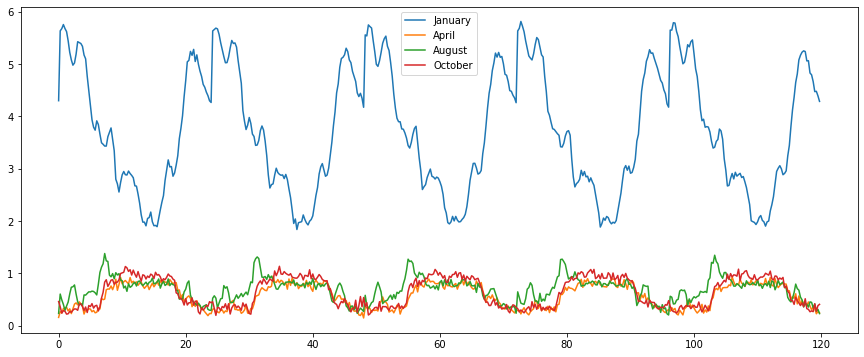

In [56]:
plt.figure(figsize=(15, 6))
months = ['January', 'April', 'August', 'October']
for i, load in enumerate(load_months):
    series = []
    T = 4 * 24 * 5
    for _ in range(T):
        series.append(next(load))
    plt.plot(0.25 * np.arange(0, T), series, label=months[i])
plt.title('')
plt.legend()